# NLP Project
### Goal: Create a model that best predicts programming languages of Github repositories 

### Plan 

Scrape Github repositories to exaluate the README sections and build a model that will predict which programming language is used. 
- 100 repositories used 
- 8 different models

### **Data Dictionary**

   - **Language:** Programming language used for repositort project

   - **README Content:** Description of each repository containing keywords used to make predictions

   - **Normalized:** README content normalized removing any uppercased characters, special characters, non-alpha characters, and alpha strings with 2 or less characters

   - **Stemmed:** README content reducing each word to its (psuedo)root 

   - **Lemmatized:** README content reducing each word to liguistically valid lemmas

   - **Cleaned:** README content that has been lemmatized and then removes any stopwords 

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

from requests import get
from bs4 import BeautifulSoup
import os
import json
import re
import unicodedata

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# matplotlib default plotting styles
plt.rc("patch", edgecolor="black", force_edgecolor=True)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle=":", linewidth=0.8, alpha=0.7)
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", figsize=(11, 8))
plt.rc("font", size=12.0)
plt.rc("hist", bins=25)
from wordcloud import WordCloud

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier


import acquire
import prepare
from env import github_token

### Acquire

In [2]:
# Using our acquire.py file, we scraped URL's from Github to create a Corpus of data
#acquire.scrape_github_data()

In [3]:
original_df = pd.read_json('data.json')

In [4]:
original_df.head()

,language,readme_contents,repo
0,Python,# AIDungeon2\n\n### The model for AI Dungeon2 ...,AIDungeon/AIDungeon
1,Go,"[<img src=""https://rclone.org/img/logo_on_ligh...",rclone/rclone
2,Python,# PythonPlantsVsZombies\na simple PlantsVsZomb...,marblexu/PythonPlantsVsZombies
3,Rust,"<img alt=""OrbTk"" width=""380"" src=""https://gitl...",redox-os/orbtk
4,C,# UAC Bypass In The Wild\nWindows 10 UAC bypas...,sailay1996/UAC_Bypass_In_The_Wild


In [5]:
original_df.shape

(107, 3)

In [6]:
# We can see that there are 7 null values in the language column
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 3 columns):
language           100 non-null object
readme_contents    107 non-null object
repo               107 non-null object
dtypes: object(3)
memory usage: 2.6+ KB


In [7]:
original_df.language.value_counts()

JavaScript          25
Python              20
CSS                  9
Ruby                 9
Go                   7
Java                 5
HTML                 5
TypeScript           4
C++                  4
PHP                  2
C                    2
Jupyter Notebook     2
Rust                 1
CoffeeScript         1
Clojure              1
C#                   1
Haskell              1
Kotlin               1
Name: language, dtype: int64

In [8]:
# Drop any columns that do not have a language
original_df = original_df.dropna()

In [9]:
original_df.shape

(100, 3)

In [10]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 106
Data columns (total 3 columns):
language           100 non-null object
readme_contents    100 non-null object
repo               100 non-null object
dtypes: object(3)
memory usage: 3.1+ KB


### Prepare

In [11]:
# Make a copy of the original data frame we brought in dropping the repo column
df = original_df[['language', 'readme_contents']]

In [12]:
df.head()

,language,readme_contents
0,Python,# AIDungeon2\n\n### The model for AI Dungeon2 ...
1,Go,"[<img src=""https://rclone.org/img/logo_on_ligh..."
2,Python,# PythonPlantsVsZombies\na simple PlantsVsZomb...
3,Rust,"<img alt=""OrbTk"" width=""380"" src=""https://gitl..."
4,C,# UAC Bypass In The Wild\nWindows 10 UAC bypas...


In [13]:
df = prepare.prep_contents(df)

In [14]:
# Using a function from our prepare.py file, we created a new df displaying new columns using different methods to clean up the data
df.head()

,language,readme_contents,original,normalized,stemmed,lemmatized,cleaned
0,Python,# AIDungeon2\n\n### The model for AI Dungeon2 ...,# AIDungeon2\n\n### The model for AI Dungeon2 ...,aidungeon the model for dungeon tempo...,aidungeon the model for dungeon temporarili un...,aidungeon the model for dungeon temporarily un...,aidungeon model dungeon temporarily unavailabl...
1,Go,"[<img src=""https://rclone.org/img/logo_on_ligh...","[<img src=""https://rclone.org/img/logo_on_ligh...",img src https rclone org img logo light h...,img src http rclone org img logo light horizon...,img src http rclone org img logo light horizon...,img src org img logo light horizontal color sv...
2,Python,# PythonPlantsVsZombies\na simple PlantsVsZomb...,# PythonPlantsVsZombies\na simple PlantsVsZomb...,pythonplantsvszombies simple plantsvszombies ...,pythonplantsvszombi simpl plantsvszombi game i...,pythonplantsvszombies simple plantsvszombies g...,pythonplantsvszombies simple plantsvszombies g...
3,Rust,"<img alt=""OrbTk"" width=""380"" src=""https://gitl...","<img alt=""OrbTk"" width=""380"" src=""https://gitl...",img alt orbtk width src https gitla...,img alt orbtk width src http gitlab redox org ...,img alt orbtk width src http gitlab redox org ...,img alt width src gitlab redox org redox asset...
4,C,# UAC Bypass In The Wild\nWindows 10 UAC bypas...,# UAC Bypass In The Wild\nWindows 10 UAC bypas...,uac bypass the wild windows uac bypass for...,uac bypass the wild window uac bypass for all ...,uac bypass the wild window uac bypass for all ...,uac bypass wild window uac bypass executable f...


In [15]:
# Since we created a new column titled 'original', we will drop readme_contents column
df = df.drop(columns='readme_contents')

In [16]:
df.head(2)

,language,original,normalized,stemmed,lemmatized,cleaned
0,Python,# AIDungeon2\n\n### The model for AI Dungeon2 ...,aidungeon the model for dungeon tempo...,aidungeon the model for dungeon temporarili un...,aidungeon the model for dungeon temporarily un...,aidungeon model dungeon temporarily unavailabl...
1,Go,"[<img src=""https://rclone.org/img/logo_on_ligh...",img src https rclone org img logo light h...,img src http rclone org img logo light horizon...,img src http rclone org img logo light horizon...,img src org img logo light horizontal color sv...


In [17]:
# Look at the contents using the cleaned column to assure it is cleaned up as we want it to be
df.cleaned[0]

'aidungeon model dungeon temporarily unavailable download due cost working solution read aidungeon wa built pcc byu edu dungeon creating infinitely generated text adventure deep learning language model play game colab aidungeon play game locally recommended nvidia gpu memory cuda installed gpu turn take couple minute game compose response install play locally git clone aidungeon aidungeon aidungeon install python play community aidungeon open source project question discussion contribution welcome contribution anything new package bugfixes documentation even new core feature resource website aidungeon aidungeon aidungeon twitter creator nickwalton twitter nickwalton dev benjbay twitter benjbay reddit aidungeon reddit aidungeon discord aidungeon discord discord vcz contributing contributing aidungeon relatively easy send pull request help article using pull request fork send request make develop destination branch aidungeon repository nickwalton aidungeon prefer pr pep python org dev pe

**Takeaway:** Moving forward, we will use the 'cleanded' column to explore and model. We chose to move forward with the lemmatized and removed stopwords column due to the fact that lemmatize is more accurate than stemming, working with a dictionary rather than guessing the word.


### Explore

In [18]:
df.language.value_counts()

JavaScript          25
Python              20
CSS                  9
Ruby                 9
Go                   7
Java                 5
HTML                 5
TypeScript           4
C++                  4
PHP                  2
C                    2
Jupyter Notebook     2
Rust                 1
CoffeeScript         1
Clojure              1
C#                   1
Haskell              1
Kotlin               1
Name: language, dtype: int64

In [19]:
df.language.count()

100

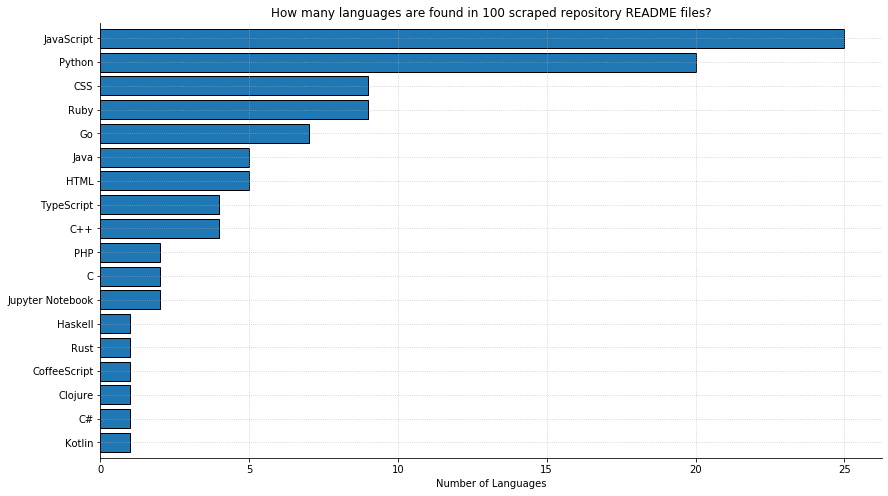

In [20]:
plt.figure(figsize=(14,8))
df.language.value_counts().sort_values(ascending=True).plot.barh(width=.8)
plt.title('How many languages are found in 100 scraped repository README files?')
plt.xlabel('Number of Languages')
plt.show()

In [21]:
# We created a new df to display the number of times a language appears abd the percentages that each programming language is featured in our corpus
percents = pd.concat(
    [df.language.value_counts(), df.language.value_counts(normalize=True)], axis=1
).set_axis(["n", "percent"], axis=1, inplace=False)
percents

,n,percent
JavaScript,25,0.25
Python,20,0.20
CSS,9,0.09
Ruby,9,0.09
Go,7,0.07
Java,5,0.05
HTML,5,0.05
TypeScript,4,0.04
C++,4,0.04
PHP,2,0.02


In [22]:
# Moving forward with the cleaned column from our df, we will create a new series splitting the words
raw_count = pd.Series(" ".join(df.cleaned).split()).value_counts()
raw_count

org                634
img                558
file               514
src                489
svg                470
html               394
code               384
use                364
doc                354
href               324
master             316
project            315
license            301
cs                 292
plugin             275
badge              274
build              269
using              254
run                249
install            230
line               230
png                217
image              211
python             208
release            205
version            204
opencollective     197
example            197
test               196
new                196
                  ... 
reescrever           1
zvrw                 1
feat                 1
downloadinstall      1
throwing             1
ogfv                 1
articulacion         1
chevron              1
interceptor          1
usefulness           1
multiplo             1
composing            1
hang       

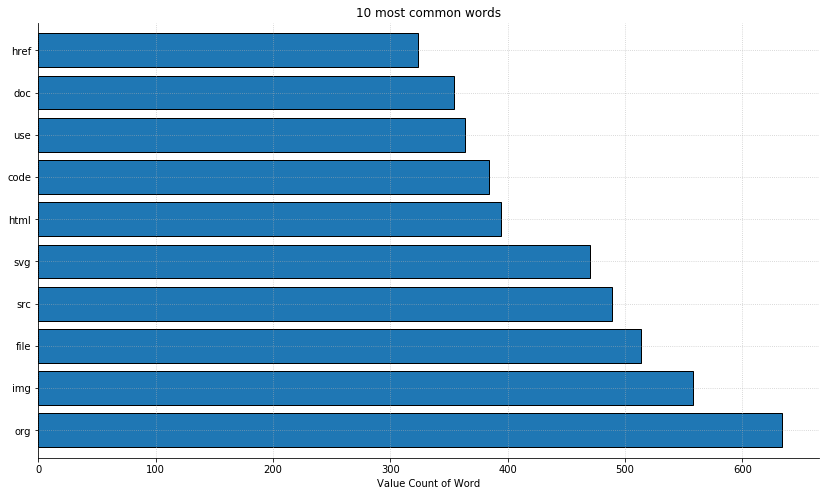

In [23]:
plt.figure(figsize=(14,8))
raw_count.sort_values(ascending=False)[0:10].plot.barh(width=.8)
plt.title('10 most common words')
plt.xlabel('Value Count of Word')
plt.show()

In [24]:
tf_df = (pd.DataFrame({'raw_count': raw_count})
         .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
         .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

tf_df.head()

,raw_count,frequency,augmented_frequency
org,634,0.008636,1.000000
img,558,0.007600,0.880126
file,514,0.007001,0.810726
src,489,0.006661,0.771293
svg,470,0.006402,0.741325


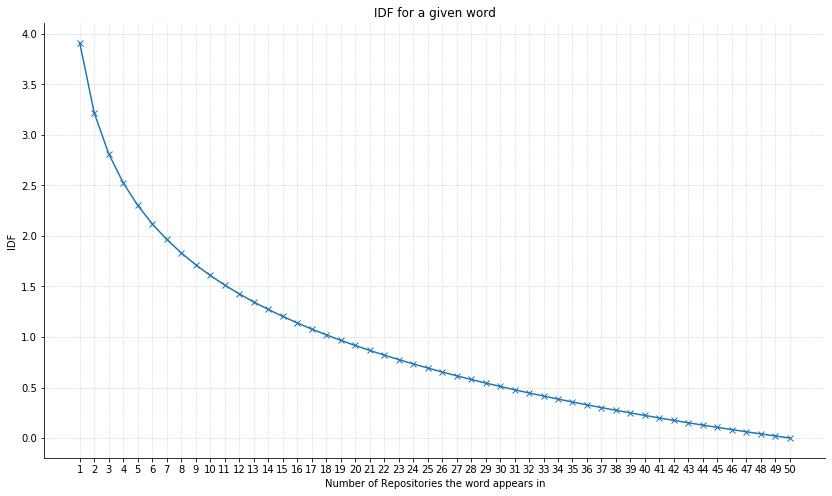

In [25]:
n_documents = 50

x_denominator = np.arange(1, n_documents + 1)
y_idf = np.log(n_documents / x_denominator)

plt.figure(figsize=(14, 8))
plt.plot(x_denominator, y_idf, marker='x')

plt.xticks(x_denominator)
plt.xlabel('Number of Repositories the word appears in')
plt.ylabel('IDF')
plt.title('IDF for a given word')
plt.show()

In [26]:
def idf(word):
    n_occurrences = sum([1 for doc in df.cleaned if word in doc])
    n_docs = len(df.cleaned)
    idf = np.log(n_docs/n_occurrences)
    return idf

In [27]:
unique_words = pd.Series(' '.join(df.cleaned).split()).unique()

In [28]:
unique_words

array(['aidungeon', 'model', 'dungeon', ..., 'healthy', 'downstream',
       'schema'], dtype=object)

In [29]:
# put in a dataframe
idf_df = pd.DataFrame(dict(word = unique_words))\
    .assign(idf = lambda df: df.word.apply(idf))\
    .set_index('word').sort_values(by='idf', ascending = False)

idf_df.head(10)

,idf
word,
aidungeon,4.60517
prerelease,4.60517
rollout,4.60517
zoomin,4.60517
diligently,4.60517
relating,4.60517
zoomindown,4.60517
zoominleft,4.60517
externally,4.60517


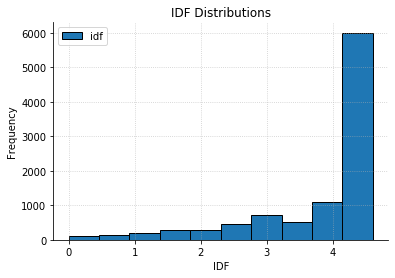

In [30]:
idf_df.plot.hist()
plt.title('IDF Distributions')
plt.xlabel('IDF')
plt.show()

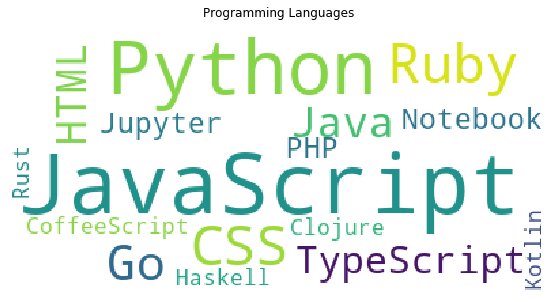

In [31]:
# Programming language value counts 
all_cloud = WordCloud(background_color='white').generate(' '.join(df.language))
plt.figure(figsize=(12, 5))
plt.imshow(all_cloud)
plt.title('Programming Languages')
plt.axis('off')
plt.show()

In [32]:
all_text = " ".join(df.cleaned)

In [33]:
all_words = prepare.clean(all_text)
all_words

['aidungeon',
 'model',
 'dungeon',
 'temporarily',
 'unavailable',
 'download',
 'due',
 'cost',
 'working',
 'solution',
 'read',
 'aidungeon',
 'wa',
 'built',
 'pcc',
 'byu',
 'edu',
 'dungeon',
 'creating',
 'infinitely',
 'generated',
 'text',
 'adventure',
 'deep',
 'learning',
 'language',
 'model',
 'play',
 'game',
 'colab',
 'aidungeon',
 'play',
 'game',
 'locally',
 'recommended',
 'nvidia',
 'gpu',
 'memory',
 'cuda',
 'installed',
 'gpu',
 'turn',
 'take',
 'couple',
 'minute',
 'game',
 'compose',
 'response',
 'install',
 'play',
 'locally',
 'git',
 'clone',
 'aidungeon',
 'aidungeon',
 'aidungeon',
 'install',
 'python',
 'play',
 'community',
 'aidungeon',
 'open',
 'source',
 'project',
 'question',
 'discussion',
 'contribution',
 'welcome',
 'contribution',
 'anything',
 'new',
 'package',
 'bugfixes',
 'documentation',
 'even',
 'new',
 'core',
 'feature',
 'resource',
 'website',
 'aidungeon',
 'aidungeon',
 'aidungeon',
 'twitter',
 'creator',
 'nickwalton',
 

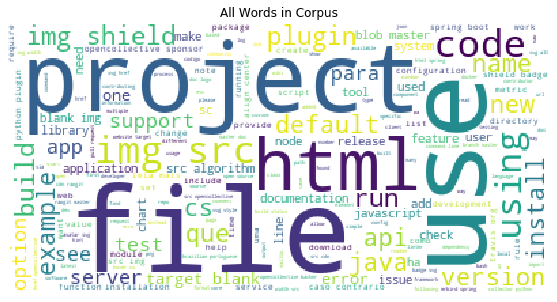

In [34]:
# Word cloud looking at all words in our corpus
img = WordCloud(background_color="white").generate(all_text)
plt.figure(figsize=(12, 5))
plt.imshow(img)
plt.axis("off")
plt.title('All Words in Corpus')
plt.show()

In [35]:
list(nltk.bigrams(all_text.split()))

[('aidungeon', 'model'),
 ('model', 'dungeon'),
 ('dungeon', 'temporarily'),
 ('temporarily', 'unavailable'),
 ('unavailable', 'download'),
 ('download', 'due'),
 ('due', 'cost'),
 ('cost', 'working'),
 ('working', 'solution'),
 ('solution', 'read'),
 ('read', 'aidungeon'),
 ('aidungeon', 'wa'),
 ('wa', 'built'),
 ('built', 'pcc'),
 ('pcc', 'byu'),
 ('byu', 'edu'),
 ('edu', 'dungeon'),
 ('dungeon', 'creating'),
 ('creating', 'infinitely'),
 ('infinitely', 'generated'),
 ('generated', 'text'),
 ('text', 'adventure'),
 ('adventure', 'deep'),
 ('deep', 'learning'),
 ('learning', 'language'),
 ('language', 'model'),
 ('model', 'play'),
 ('play', 'game'),
 ('game', 'colab'),
 ('colab', 'aidungeon'),
 ('aidungeon', 'play'),
 ('play', 'game'),
 ('game', 'locally'),
 ('locally', 'recommended'),
 ('recommended', 'nvidia'),
 ('nvidia', 'gpu'),
 ('gpu', 'memory'),
 ('memory', 'cuda'),
 ('cuda', 'installed'),
 ('installed', 'gpu'),
 ('gpu', 'turn'),
 ('turn', 'take'),
 ('take', 'couple'),
 ('coupl

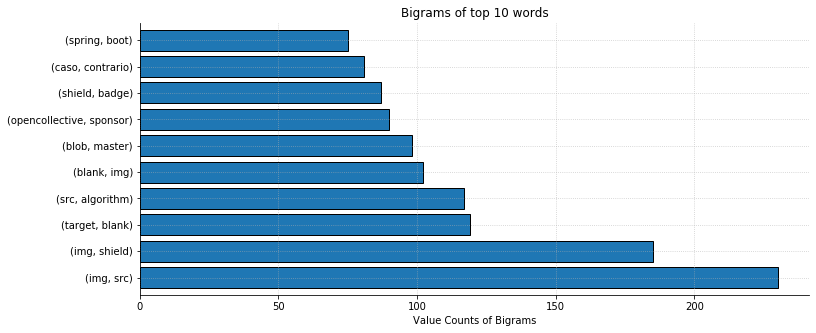

In [36]:
plt.figure(figsize=(12,5))
pd.Series(nltk.bigrams(all_words)).value_counts().head(10).plot.barh(width=.8)
plt.title('Bigrams of top 10 words')
plt.xlabel('Value Counts of Bigrams')
plt.show()

In [37]:
list(nltk.ngrams(all_text.split(), 3))

[('aidungeon', 'model', 'dungeon'),
 ('model', 'dungeon', 'temporarily'),
 ('dungeon', 'temporarily', 'unavailable'),
 ('temporarily', 'unavailable', 'download'),
 ('unavailable', 'download', 'due'),
 ('download', 'due', 'cost'),
 ('due', 'cost', 'working'),
 ('cost', 'working', 'solution'),
 ('working', 'solution', 'read'),
 ('solution', 'read', 'aidungeon'),
 ('read', 'aidungeon', 'wa'),
 ('aidungeon', 'wa', 'built'),
 ('wa', 'built', 'pcc'),
 ('built', 'pcc', 'byu'),
 ('pcc', 'byu', 'edu'),
 ('byu', 'edu', 'dungeon'),
 ('edu', 'dungeon', 'creating'),
 ('dungeon', 'creating', 'infinitely'),
 ('creating', 'infinitely', 'generated'),
 ('infinitely', 'generated', 'text'),
 ('generated', 'text', 'adventure'),
 ('text', 'adventure', 'deep'),
 ('adventure', 'deep', 'learning'),
 ('deep', 'learning', 'language'),
 ('learning', 'language', 'model'),
 ('language', 'model', 'play'),
 ('model', 'play', 'game'),
 ('play', 'game', 'colab'),
 ('game', 'colab', 'aidungeon'),
 ('colab', 'aidungeon',

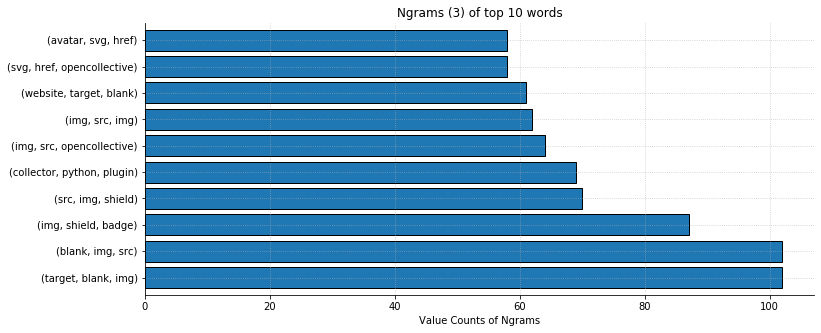

In [38]:
plt.figure(figsize=(12,5))
pd.Series(nltk.ngrams(all_words, 3)).value_counts().head(10).plot.barh(width=.8)
plt.title('Ngrams (3) of top 10 words')
plt.xlabel('Value Counts of Ngrams')
plt.show()

In [39]:
top_25_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(25))

top_25_bigrams

(img, src)                   230
(img, shield)                185
(target, blank)              119
(src, algorithm)             117
(blank, img)                 102
(blob, master)                98
(opencollective, sponsor)     90
(shield, badge)               87
(caso, contrario)             81
(spring, boot)                75
(align, center)               74
(travis, org)                 72
(leia, mais)                  72
(avatar, svg)                 71
(python, plugin)              71
(src, img)                    71
(opencollective, backer)      71
(collector, python)           69
(command, line)               67
(brazilian, portuguese)       66
(html, spring)                65
(src, opencollective)         64
(master, doc)                 64
(build, status)               62
(mrbird, spring)              62
dtype: int64

In [41]:
df["readme_length"] = df.cleaned.apply(len)

In [42]:
df.head()

,language,original,normalized,stemmed,lemmatized,cleaned,readme_length
0,Python,# AIDungeon2\n\n### The model for AI Dungeon2 ...,aidungeon the model for dungeon tempo...,aidungeon the model for dungeon temporarili un...,aidungeon the model for dungeon temporarily un...,aidungeon model dungeon temporarily unavailabl...,1206
1,Go,"[<img src=""https://rclone.org/img/logo_on_ligh...",img src https rclone org img logo light h...,img src http rclone org img logo light horizon...,img src http rclone org img logo light horizon...,img src org img logo light horizontal color sv...,3289
2,Python,# PythonPlantsVsZombies\na simple PlantsVsZomb...,pythonplantsvszombies simple plantsvszombies ...,pythonplantsvszombi simpl plantsvszombi game i...,pythonplantsvszombies simple plantsvszombies g...,pythonplantsvszombies simple plantsvszombies g...,705
3,Rust,"<img alt=""OrbTk"" width=""380"" src=""https://gitl...",img alt orbtk width src https gitla...,img alt orbtk width src http gitlab redox org ...,img alt orbtk width src http gitlab redox org ...,img alt width src gitlab redox org redox asset...,3541
4,C,# UAC Bypass In The Wild\nWindows 10 UAC bypas...,uac bypass the wild windows uac bypass for...,uac bypass the wild window uac bypass for all ...,uac bypass the wild window uac bypass for all ...,uac bypass wild window uac bypass executable f...,339


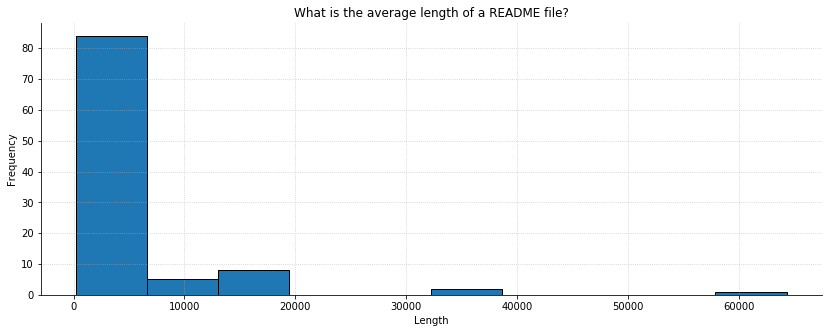

In [43]:
plt.figure(figsize=(14,5))
df.readme_length.plot.hist()
plt.title('What is the average length of a README file?')
plt.xlabel('Length')
plt.show()

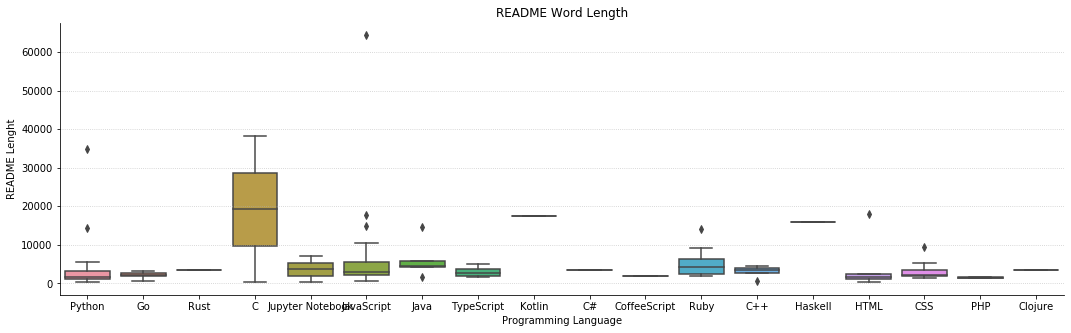

In [47]:
plt.figure(figsize=(18,5))
sns.boxplot(data=df, y="readme_length", x='language')
plt.title("README Word Length")
plt.xlabel('Programming Language')
plt.ylabel('README Lenght')
plt.show()

In [ ]:
# Do different programming languages use a different number of unique words?

In [50]:
java = df[df.language == 'JavaScript'].sort_values(by='readme_length', ascending=True)
java.head()

,language,original,normalized,stemmed,lemmatized,cleaned,readme_length
83,JavaScript,# Cumulus\nA SoundCloud player that lives in y...,cumulus soundcloud player that lives your me...,cumulu soundcloud player that live your menuba...,cumulus soundcloud player that life your menub...,cumulus soundcloud player life menubar release...,619
56,JavaScript,## [What Is Code?](http://www.bloomberg.com/wh...,what code http www bloomberg com whatisco...,what code http www bloomberg com whatiscod bus...,what code http www bloomberg com whatiscode bu...,code bloomberg businessweek june paul ford twi...,892
96,JavaScript,# Graphite-Web\n\n[![Codacy Badge](https://api...,graphite web codacy badge https api cod...,graphit web codaci badg http api codaci com pr...,graphite web codacy badge http api codacy com ...,graphite web codacy badge api codacy project b...,1174
29,JavaScript,# CSScomb [![CSSComb](logo.png)](http://csscom...,csscomb csscomb logo png http csscomb ...,csscomb csscomb logo png http csscomb com buil...,csscomb csscomb logo png http csscomb com buil...,logo png build status travis org svg branch ma...,1787
49,JavaScript,"# Meme v.2\n\nContributors: Yuri Victor, Joshu...",meme contributors yuri victor joshua ben...,meme contributor yuri victor joshua benton mat...,meme contributor yuri victor joshua benton mat...,contributor yuri victor joshua benton matt mon...,1979


In [55]:
java_words = pd.Series(" ".join(java.cleaned).split()).value_counts()
java_words.head(15)

src          309
img          257
que          189
para         169
org          169
doc          153
svg          139
mais         128
algorithm    125
png          124
href         123
master       119
npm          111
use          104
uma          103
dtype: int64

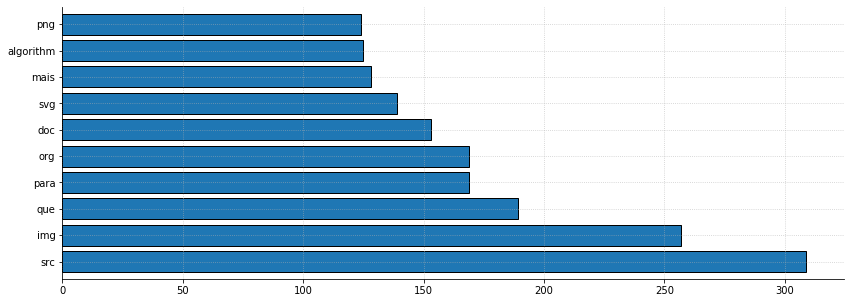

In [58]:
plt.figure(figsize=(14,5))
java_words.sort_values(ascending=False)[0:10].plot.barh(width=.8)
plt.show()

In [71]:
# is this relevant?
unique_java = pd.Series(' '.join(java.cleaned).split()).unique()
unique_java

array(['cumulus', 'soundcloud', 'player', ..., 'refack', 'refael',
       'ackermann'], dtype=object)

In [60]:
python = df[df.language == 'Python'].sort_values(by='readme_length', ascending=True)
python.head()

,language,original,normalized,stemmed,lemmatized,cleaned,readme_length
43,Python,[![Build Status](https://dev.azure.com/asottil...,build status https dev azure com asottile a...,build statu http dev azur com asottil asottil ...,build status http dev azure com asottile asott...,build status dev azure asottile asottile apis ...,426
92,Python,OpenStack Tracking Repo\n=====================...,openstack tracking repo ...,openstack track repo zuul gate all the contain...,openstack tracking repo zuul gate all the cont...,tracking repo zuul gate contained project effe...,456
98,Python,Welcome to Fabric!\n==================\n\nFabr...,welcome fabric fabric ...,welcom fabric fabric high level python librari...,welcome fabric fabric high level python librar...,welcome high level python library designed exe...,465
2,Python,# PythonPlantsVsZombies\na simple PlantsVsZomb...,pythonplantsvszombies simple plantsvszombies ...,pythonplantsvszombi simpl plantsvszombi game i...,pythonplantsvszombies simple plantsvszombies g...,pythonplantsvszombies simple plantsvszombies g...,705
102,Python,".. raw:: html\n\n <p align=""center"">\n <...",raw html align center align ...,raw html align center align center href http s...,raw html align center align center href http s...,raw html align center align center href utm so...,883


In [62]:
python_words = pd.Series(" ".join(python.cleaned).split()).value_counts()
python_words.head(15)

file       161
bee        152
line       137
code       108
python     107
org         86
content     70
use         69
img         68
mean        68
style       66
mailto      62
pre         61
fixed       60
target      59
dtype: int64

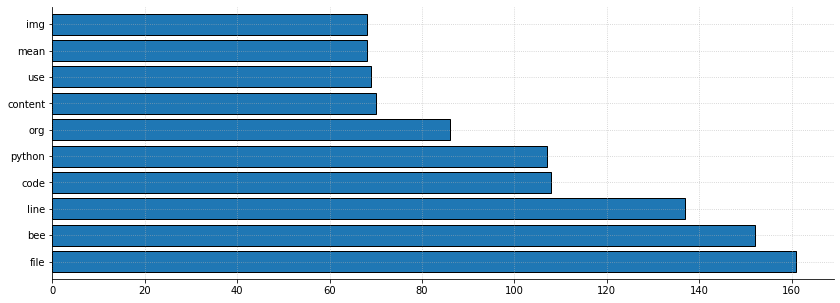

In [64]:
plt.figure(figsize=(14,5))
python_words.sort_values(ascending=False)[0:10].plot.barh(width=.8)
plt.show()

In [73]:
css = df[df.language == 'CSS'].sort_values(by='readme_length', ascending=True)
css.head()

,language,original,normalized,stemmed,lemmatized,cleaned,readme_length
61,CSS,960 Grid System\n===============\n\nCreated by...,grid system created nathan s...,grid system creat nathan smith see the offici ...,grid system created nathan smith see the offic...,grid system created nathan smith see official ...,1349
71,CSS,# Basscss\n\nLow-level CSS toolkit – the origi...,basscss low level css toolkit the original ...,basscss low level css toolkit the origin funct...,basscss low level cs toolkit the original func...,low level cs toolkit original functional cs fu...,1882
70,CSS,# [Photon](http://photonkit.com/)\n\n[![Build ...,photon http photonkit com build statu...,photon http photonkit com build statu http img...,photon http photonkit com build status http im...,photonkit build status img shield travis maste...,1941
64,CSS,\n# [Flat UI Free](https://designmodo.github.i...,flat free https designmodo github flat ...,flat free http designmodo github flat flat bea...,flat free http designmodo github flat flat bea...,flat free flat flat beautiful theme getbootstr...,2201
62,CSS,"# normalize.css\n\n<a href=""https://github.com...",normalize css href https github com neco...,normal css href http github com necola normal ...,normalize cs href http github com necolas norm...,normalize cs href normalize cs img src normali...,2226


In [76]:
css_words = pd.Series(" ".join(css.cleaned).split()).value_counts()
css_words.head(15)

cs         207
hover       67
color       66
license     62
border      47
element     42
effect      40
class       37
use         36
stroke      36
fill        36
html        35
using       34
animate     32
file        32
dtype: int64

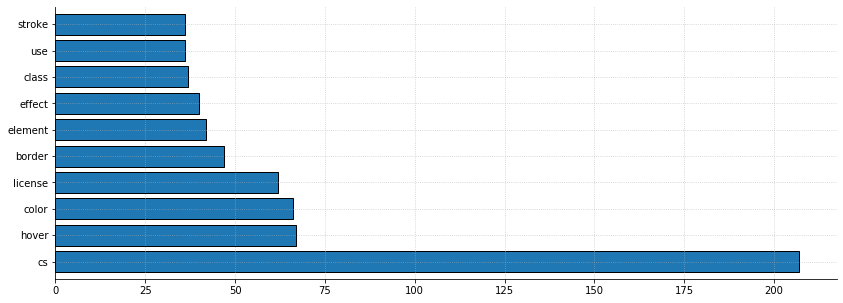

In [77]:
plt.figure(figsize=(14,5))
css_words.sort_values(ascending=False)[0:10].plot.barh(width=.8)
plt.show()

In [79]:
ruby = df[df.language == 'Ruby'].sort_values(by='readme_length', ascending=True)
css.head()

,language,original,normalized,stemmed,lemmatized,cleaned,readme_length
61,CSS,960 Grid System\n===============\n\nCreated by...,grid system created nathan s...,grid system creat nathan smith see the offici ...,grid system created nathan smith see the offic...,grid system created nathan smith see official ...,1349
71,CSS,# Basscss\n\nLow-level CSS toolkit – the origi...,basscss low level css toolkit the original ...,basscss low level css toolkit the origin funct...,basscss low level cs toolkit the original func...,low level cs toolkit original functional cs fu...,1882
70,CSS,# [Photon](http://photonkit.com/)\n\n[![Build ...,photon http photonkit com build statu...,photon http photonkit com build statu http img...,photon http photonkit com build status http im...,photonkit build status img shield travis maste...,1941
64,CSS,\n# [Flat UI Free](https://designmodo.github.i...,flat free https designmodo github flat ...,flat free http designmodo github flat flat bea...,flat free http designmodo github flat flat bea...,flat free flat flat beautiful theme getbootstr...,2201
62,CSS,"# normalize.css\n\n<a href=""https://github.com...",normalize css href https github com neco...,normal css href http github com necola normal ...,normalize cs href http github com necolas norm...,normalize cs href normalize cs img src normali...,2226


In [80]:
ruby_words = pd.Series(" ".join(ruby.cleaned).split()).value_counts()
ruby_words.head(15)

sc                155
opencollective    128
svg               124
file               90
org                69
sponsor            68
sonic              65
backer             65
img                65
website            64
src                62
target             61
href               60
avatar             60
blank              60
dtype: int64

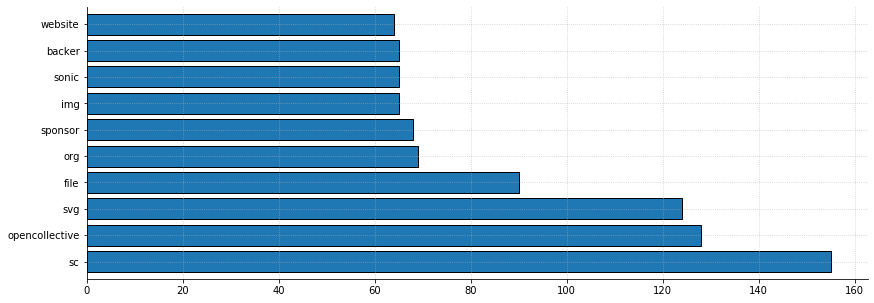

In [83]:
plt.figure(figsize=(14,5))
ruby_words.sort_values(ascending=False)[0:10].plot.barh(width=.8)
plt.show()

In [84]:
go = df[df.language == 'Go'].sort_values(by='readme_length', ascending=True)
css.head()

,language,original,normalized,stemmed,lemmatized,cleaned,readme_length
61,CSS,960 Grid System\n===============\n\nCreated by...,grid system created nathan s...,grid system creat nathan smith see the offici ...,grid system created nathan smith see the offic...,grid system created nathan smith see official ...,1349
71,CSS,# Basscss\n\nLow-level CSS toolkit – the origi...,basscss low level css toolkit the original ...,basscss low level css toolkit the origin funct...,basscss low level cs toolkit the original func...,low level cs toolkit original functional cs fu...,1882
70,CSS,# [Photon](http://photonkit.com/)\n\n[![Build ...,photon http photonkit com build statu...,photon http photonkit com build statu http img...,photon http photonkit com build status http im...,photonkit build status img shield travis maste...,1941
64,CSS,\n# [Flat UI Free](https://designmodo.github.i...,flat free https designmodo github flat ...,flat free http designmodo github flat flat bea...,flat free http designmodo github flat flat bea...,flat free flat flat beautiful theme getbootstr...,2201
62,CSS,"# normalize.css\n\n<a href=""https://github.com...",normalize css href https github com neco...,normal css href http github com necola normal ...,normalize cs href http github com necolas norm...,normalize cs href normalize cs img src normali...,2226


In [85]:
go_words = pd.Series(" ".join(go.cleaned).split()).value_counts()
go_words.head(15)

org          105
page          45
build         43
facing        43
client        27
docker        23
golint        22
project       22
cloud         21
master        19
godoc         18
run           18
doc           17
container     16
file          16
dtype: int64

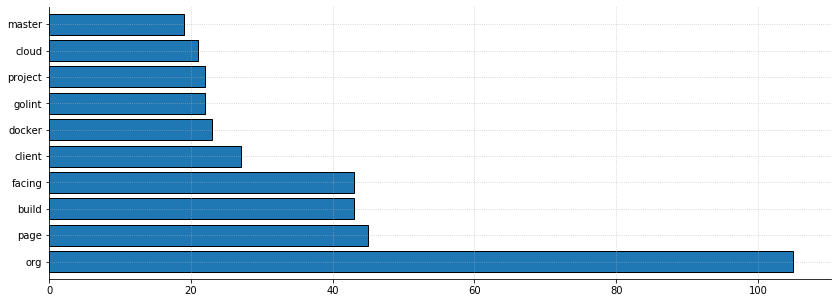

In [86]:
plt.figure(figsize=(14,5))
go_words.sort_values(ascending=False)[0:10].plot.barh(width=.8)
plt.show()

### Model

In [ ]:
# We want to look into the languages with only one appearance and remove those in order to run our models
df.language.value_counts()[df.language.value_counts() == 1]

In [ ]:
list(df.language.value_counts()[df.language.value_counts() == 1].index)

In [ ]:
df[df.language == 'Kotlin']
df = df.drop(20)
df[df.language == 'C#']
df = df.drop(21)
df[df.language == 'CoffeeScript']
df = df.drop(28)
df[df.language == 'Clojure']
df = df.drop(85)
df[df.language == 'Haskell']
df = df.drop(41)
df[df.language == 'Rust']
df = df.drop(3)

In [ ]:
df = df.reset_index()

In [ ]:
df.language.value_counts()

#### *Logistic Regression*

In [ ]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.cleaned)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

In [ ]:
lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [ ]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')

In [ ]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---') 
print(classification_report(test.actual, test.predicted))

#### *Decision Tree*

In [ ]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)

clf.fit(X_train, y_train)

In [ ]:
print(clf.feature_importances_)

In [ ]:
y_pred = clf.predict(X_train)
y_pred

In [ ]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba

In [ ]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

In [ ]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

In [ ]:
confusion_matrix(y_train, y_pred)

#### *Random Forest*

In [ ]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=10,
                            n_estimators=100,
                            max_depth=4, 
                            random_state=123)

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
print(rf.feature_importances_)

In [ ]:
y_pred = rf.predict(X_train)
y_pred

In [ ]:
y_pred_proba = rf.predict_proba(X_train)
y_pred_proba

In [ ]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

In [ ]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

In [ ]:
print(confusion_matrix(y_train, y_pred))

In [ ]:
print(classification_report(y_train, y_pred))

#### *K-Nearest Neighbors*

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [ ]:
knn.fit(X_train, y_train)

In [ ]:
y_pred = knn.predict(X_train)
y_pred

In [ ]:
y_pred_proba = knn.predict_proba(X_train)
y_pred_proba

In [ ]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

In [ ]:
print(confusion_matrix(y_train, y_pred))

In [ ]:
print(classification_report(y_train, y_pred))

In [ ]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

In [ ]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])
plt.show()

In [ ]:
rng = np.random.RandomState(1)
X = X_train
y = y_train

clf = BernoulliNB()
clf.fit(X, y)

In [ ]:
print(clf.predict(X))

In [ ]:
y_pred = clf.predict(X)
y_pred

In [ ]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba

In [ ]:
print('Accuracy of Naive Bayes classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

In [ ]:
print(classification_report(y_train, y_pred))

#### *Support Vector Machine (SVM)

In [ ]:
X = X_train
y = y_train

clf = SVC(gamma='auto', kernel='linear')
clf.fit(X, y)

In [ ]:
clf.predict(X)

In [ ]:
print('Accuracy of Stochastic SVM on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

In [ ]:
print('Accuracy of Stochastic SVM on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

#### *Stochastic Gradient Descent* 

In [ ]:
X = X_train
y = y_train
# clf = linear_model.SGDClassifier(max_iter=, tol=1e-3)
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
clf.fit(X, y)

In [ ]:
clf.predict(X)

In [ ]:
print('Accuracy of Stochastic Gradient Decent Classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

In [ ]:
print(classification_report(y_train, y_pred))

In [ ]:
print('Accuracy of Stochastic Gradient Decent classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

#### *AdaBoost*

In [ ]:
X = X_train
y = y_train
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)

In [ ]:
print(clf.feature_importances_)

In [ ]:
clf.predict(X)

In [ ]:
clf.score(X, y)

#### *Bagging*

In [ ]:
X = X_train
y = y_train

clf = BaggingClassifier(n_estimators=3, random_state=0)
clf.fit(X, y)
clf.predict(X)

In [ ]:
print('Accuracy of Bagging classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

In [ ]:
clf.score(X_test, y_test)

In [ ]:
# Best Model

### Analysis

We scraped a random collection of Github repository README's in order to gather a diverse selection of programming languages. We found from this process that the most prominent language from our scraping was JavaScrit, followed by Python and then Ruby. 

In [ ]:
# to do:
# finish writing up analysis
# finish slides - well-rounded viz
# finish exploration
# readme
# explain each model
# finish notes in notebook